# Dropout

In this notebook, you will implement dropout.  Then we will ask you to train a network with batchnorm and dropout, and acheive over 60% accuracy on CIFAR-10.

CS231n has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, and their layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.  As in prior assignments, we thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  

In [133]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from nndl.layers import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
  print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Dropout forward pass

Implement the training and test time dropout forward pass, `dropout_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [146]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())

Running tests with p =  0.3
Mean of input:  9.9983572354
Mean of train-time output:  9.99057904364
Mean of test-time output:  9.9983572354
Fraction of train-time output set to zero:  0.300788
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  9.9983572354
Mean of train-time output:  9.96138852574
Mean of test-time output:  9.9983572354
Fraction of train-time output set to zero:  0.601664
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  9.9983572354
Mean of train-time output:  10.0117355182
Mean of test-time output:  9.9983572354
Fraction of train-time output set to zero:  0.749728
Fraction of test-time output set to zero:  0.0


## Dropout backward pass

Implement the backward pass, `dropout_backward`, in `nndl/layers.py`.  After that, test your gradients by running the following cell:

In [147]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  1.89290542075e-11


## Implement a fully connected neural network with dropout layers

Modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate dropout.  A dropout layer should be incorporated after every ReLU layer.  Concretely, there shouldn't be a dropout at the output layer since there is no ReLU at the output layer. You will need to modify the class in the following areas:

(1) In the forward pass, you will need to incorporate a dropout layer after every relu layer.

(2) In the backward pass, you will need to incorporate a dropout backward pass layer.

Check your implementation by running the following code.  Our W1 gradient relative error is on the order of 1e-6 (the largest of all the relative errors).

In [148]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
  print('\n')

Running check with dropout =  0
Initial loss:  2.30519382479
W1 relative error: 7.711419522175973e-07
W2 relative error: 1.5034484932141387e-05
W3 relative error: 6.398873279808276e-07
b1 relative error: 2.9369574464090924e-06
b2 relative error: 6.320762652162454e-07
b3 relative error: 5.016029374797846e-07


Running check with dropout =  0.25
Initial loss:  2.29898515115
W1 relative error: 6.35222787011374e-06
W2 relative error: 5.687120844147058e-07
W3 relative error: 5.275962590939497e-07
b1 relative error: 5.030395134204798e-07
b2 relative error: 5.077063628933062e-07
b3 relative error: 5.009812500135304e-07


Running check with dropout =  0.5
Initial loss:  2.30243658786
W1 relative error: 5.836138382264886e-07
W2 relative error: 5.424266743801599e-07
W3 relative error: 8.333513391763223e-07
b1 relative error: 5.000127105947692e-07
b2 relative error: 5.057022318569306e-07
b3 relative error: 5.001185713330327e-07




## Dropout as a regularizer

In class, we claimed that dropout acts as a regularizer by effectively bagging.  To check this, we will train two small networks, one with dropout and one without dropout.  

In [149]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.6]
for dropout in dropout_choices:
  model = FullyConnectedNet([100, 100, 100], dropout=dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

(Iteration 1 / 125) loss: 2.300804
(Epoch 0 / 25) train acc: 0.220000; val_acc: 0.168000
(Epoch 1 / 25) train acc: 0.188000; val_acc: 0.147000
(Epoch 2 / 25) train acc: 0.266000; val_acc: 0.200000
(Epoch 3 / 25) train acc: 0.338000; val_acc: 0.262000
(Epoch 4 / 25) train acc: 0.378000; val_acc: 0.278000
(Epoch 5 / 25) train acc: 0.428000; val_acc: 0.297000
(Epoch 6 / 25) train acc: 0.468000; val_acc: 0.323000
(Epoch 7 / 25) train acc: 0.494000; val_acc: 0.287000
(Epoch 8 / 25) train acc: 0.566000; val_acc: 0.328000
(Epoch 9 / 25) train acc: 0.572000; val_acc: 0.322000
(Epoch 10 / 25) train acc: 0.622000; val_acc: 0.324000
(Epoch 11 / 25) train acc: 0.670000; val_acc: 0.279000
(Epoch 12 / 25) train acc: 0.710000; val_acc: 0.338000
(Epoch 13 / 25) train acc: 0.746000; val_acc: 0.319000
(Epoch 14 / 25) train acc: 0.792000; val_acc: 0.307000
(Epoch 15 / 25) train acc: 0.834000; val_acc: 0.297000
(Epoch 16 / 25) train acc: 0.876000; val_acc: 0.327000
(Epoch 17 / 25) train acc: 0.886000; val

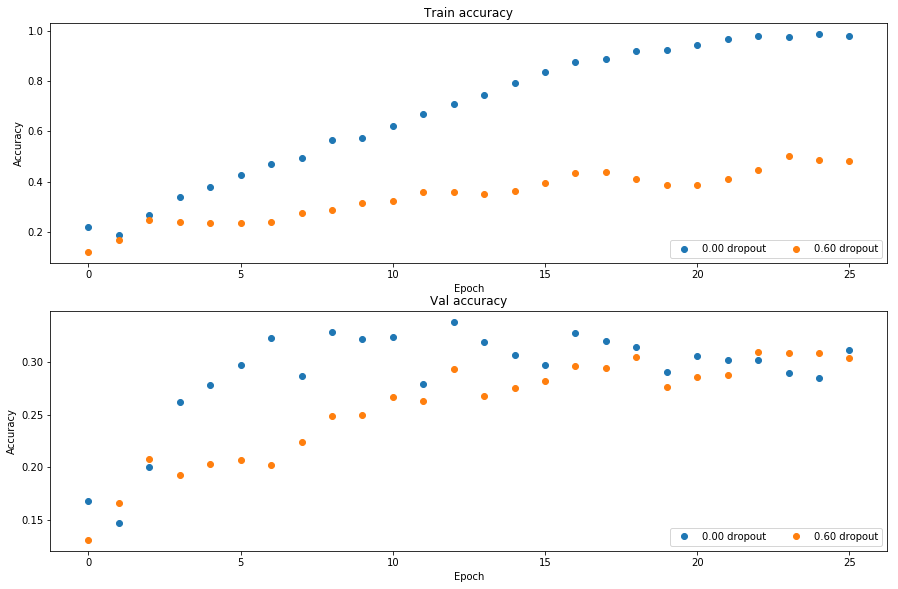

In [150]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Question

Based off the results of this experiment, is dropout performing regularization?  Explain your answer.

## Answer:
Dropout is performing regularization. The train accuracy is lower and the validation accuracy is marginally higher. Dropout is essentially forcing the trained classifier to generalize well by randomly dropping certain neurons in each hidden layer. The expectation is that for deep neural networks, the validation error will be significantly better.

## Final part of the assignment

Get over 60% validation accuracy on CIFAR-10 by using the layers you have implemented.  You will be graded according to the following equation:

min(floor((X - 32%)) / 28%, 1) 
where if you get 60% or higher validation accuracy, you get full points.

In [163]:
# ================================================================ #
# YOUR CODE HERE:
#   Implement a FC-net that achieves at least 60% validation accuracy
#   on CIFAR-10.
# ================================================================ #
import itertools

full_data = {
  'X_train': data['X_train'],#[:num_train],
  'y_train': data['y_train'],#[:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

print(full_data['X_train'].shape)

dropout_choices = [0.1, 0.2]#, 0.1, 0.2, 0.3] #0.3,0.4,0.5, 0.6]
#learning_rates = [5e-3]#[1e-4, 2e-4, 5e-4, 6e-4]
#batch_sizes = [500]#[100, 200, 300, 400, 500]
num_per_layer = [ 500]#[50, 100, 200, 300]
num_layers = [4]#, 5, 6]

combos = list( itertools.product(dropout_choices, num_per_layer, num_layers))
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []

i = 0
for combo in combos:
    print("combo: ", i)
    print(combo)
    dropout = combo[0]
    num_per_layer = int(combo[1])
    num_layers = int(combo[2])
    
    net_config = [num_per_layer for nl in range(num_layers)]
    #print(net_config)
    #break
     
    optimizer = 'adam'

    weight_scale = 0.01
    learning_rate = 1e-3
    lr_decay = 0.9

    model = FullyConnectedNet(net_config, weight_scale=weight_scale,
                              dropout=dropout, use_batchnorm=True)

    solver = Solver(model, data,
                    num_epochs=10, batch_size=100,
                    update_rule=optimizer,
                    optim_config={
                      'learning_rate': learning_rate,
                    },
                    lr_decay=lr_decay,
                    verbose=True, print_every=50)
    solver.train()

   
#  solvers[dropout] = solver

    print("Train acc: ", solver.train_acc_history[-1], " || Val acc: ", solver.val_acc_history[-1])
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])
    
    if(solver.val_acc_history[-1] >= 0.6):
        break
        
    i += 1
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #
#
#4 layer
#(Epoch 10 / 10) train acc: 0.740000; val_acc: 0.573000
#Train acc:  0.74  || Val acc:  0.573


(49000, 3, 32, 32)
combo:  0
(0.1, 500, 4)
(Iteration 1 / 4900) loss: 2.296913
(Epoch 0 / 10) train acc: 0.180000; val_acc: 0.190000
(Iteration 51 / 4900) loss: 1.741179
(Iteration 101 / 4900) loss: 1.616187
(Iteration 151 / 4900) loss: 1.627492
(Iteration 201 / 4900) loss: 2.017857
(Iteration 251 / 4900) loss: 1.714556
(Iteration 301 / 4900) loss: 1.477805
(Iteration 351 / 4900) loss: 1.526273
(Iteration 401 / 4900) loss: 1.432306
(Iteration 451 / 4900) loss: 1.496049
(Epoch 1 / 10) train acc: 0.466000; val_acc: 0.465000
(Iteration 501 / 4900) loss: 1.467826
(Iteration 551 / 4900) loss: 1.368999
(Iteration 601 / 4900) loss: 1.402684
(Iteration 651 / 4900) loss: 1.366997
(Iteration 701 / 4900) loss: 1.394733
(Iteration 751 / 4900) loss: 1.304383
(Iteration 801 / 4900) loss: 1.481736
(Iteration 851 / 4900) loss: 1.434304
(Iteration 901 / 4900) loss: 1.329715
(Iteration 951 / 4900) loss: 1.201515
(Epoch 2 / 10) train acc: 0.549000; val_acc: 0.511000
(Iteration 1001 / 4900) loss: 1.420237

(Iteration 4151 / 4900) loss: 1.242961
(Iteration 4201 / 4900) loss: 0.998609
(Iteration 4251 / 4900) loss: 1.025409
(Iteration 4301 / 4900) loss: 0.995536
(Iteration 4351 / 4900) loss: 1.069902
(Iteration 4401 / 4900) loss: 1.035483
(Epoch 9 / 10) train acc: 0.700000; val_acc: 0.564000
(Iteration 4451 / 4900) loss: 0.926242
(Iteration 4501 / 4900) loss: 0.739709
(Iteration 4551 / 4900) loss: 1.189041
(Iteration 4601 / 4900) loss: 1.003469
(Iteration 4651 / 4900) loss: 1.079360
(Iteration 4701 / 4900) loss: 1.342456
(Iteration 4751 / 4900) loss: 1.079246
(Iteration 4801 / 4900) loss: 1.084932
(Iteration 4851 / 4900) loss: 1.007672
(Epoch 10 / 10) train acc: 0.730000; val_acc: 0.562000
Train acc:  0.73  || Val acc:  0.562


In [164]:
max_train = np.argmax(train_accs)
max_val = np.argmax(val_accs)

print("best train combo: ", combos[max_train])
print("best val combo: ", combos[max_val])

best train combo:  (0.1, 500, 4)
best val combo:  (0.1, 500, 4)


# Best Results

From the small sweep above and some testing done in another notebook the best configuration was: 

500 neurons per layer <br>
4 layers <br>
1e-3 learning rate <br>
0.01 weight scale <br>
0.9 lr_decay <br>

0.1 dropout <br>